# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# Proyecto 01
## Cancelación Activa de Ruido
Este trabajo desarrolla la síntesis de un sistema de cancelación activa de ruido.

<center><img src="../support/drawing/general_system.png" style='width: 640px;'></center>

#### Grupo N° 1
* DAVIDOV, Gonzalo Joaquín
* FARALL, Facundo David
* KAMMANN, Lucas Agustín
* TROZZO, Rafael Nicolás

In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

In [3]:
from scipy import signal

In [4]:
from scipy import linalg

In [5]:
import numpy as np

In [6]:
import IPython

In [187]:
def plot_anc_results(e, w=None, weight_plot='response', labels=None):
    """ Plot the results of the ANC algorithm.
        @param error_history
        @param weight_history
    """
    
    if w is not None:
        fig, ax = plt.subplots(2, 1, figsize=(10, 18))
        error_ax = ax[0]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 9))
        error_ax = ax
        
    if labels is None:
        labels = ['Ruido con filtrado pasivo', 'Ruido con ANC']
    for k, error in enumerate(e):
        error_ax.plot(error, label=labels[k])
    error_ax.set_ylabel('$e(n)$', fontsize=16)
    error_ax.set_xlabel('$n$', fontsize=16)
    error_ax.grid()
    error_ax.legend(loc='upper right', fontsize=14)
    
    if w is not None:
        if weight_plot == 'response':
            ax[1].stem(w, use_line_collection=True)
            ax[1].set_ylabel('$w_n$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
        elif weight_plot == 'history':
            for i in range(w.shape[0]):
                ax[1].plot(w[i,:])
            ax[1].set_ylabel('$w_i(n)$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()

In [8]:
def plot_signal(fs, samples, title):
    """ Plot a signal.
    """
    # Plot the signal
    plt.figure(figsize=(14, 8))
    plt.plot(samples, label=title)
    plt.tick_params(labelsize=15)
    plt.xlabel('$n$', fontsize=15)
    plt.ylabel('$x(n)$', fontsize=15)
    plt.legend(fontsize=18)
    plt.grid()
    plt.show()

In [9]:
def plot_energy_analysis(fs, samples, title, order):
    """ Plot time varying energy analysis.
    """
    # Compute the energy within a window of size order
    length = int(len(samples) / order)
    energies = np.zeros(length)
    for i in range(length):
        energies[i] = samples[i * order:(i + 1) * order].var() / order
        
    # Plot the energy
    plt.figure(figsize=(14, 8))
    plt.plot(energies, label=f'{title}')
    plt.tick_params(labelsize=15)
    plt.xlabel('$n$', fontsize=15)
    plt.ylabel('$\hat{E} [ x^{2} ] $', fontsize=15)
    plt.legend(fontsize=18)
    plt.grid()
    plt.show()

In [10]:
def estimate_correlation(x, one_sided=True):
    """ Estimates the autocorrelation function of the input signal.
        @param x Input signal x(n)
        @return rxx
    """
    # Estimate the autocorrelation using the biased estimator
    rxx = signal.correlate(x, x, method='fft') / len(x)
    if one_sided:
        rxx = rxx[len(rxx)//2:]
    return rxx

In [11]:
def plot_autocorrelation(fs, samples, title, order):
    """ Plot analysis of eigenvalues.
    """
    # Compute the eigenvalues
    rxx = estimate_correlation(samples)
    
    # Plot the energy
    plt.figure(figsize=(14, 8))
    plt.stem(rxx[:order], label=f'{title}')
    plt.tick_params(labelsize=15)
    plt.ylabel('$r_{xx}(k)$', fontsize=15)
    plt.xlabel('$k$', fontsize=15)
    plt.legend(fontsize=18)
    plt.grid()
    plt.show()

In [12]:
def plot_eigenvalues_analysis(fs, samples, title, offset, order):
    """ Plot analysis of eigenvalues.
    """
    # Compute the eigenvalues
    rxx = estimate_correlation(samples)
    R = linalg.toeplitz(rxx[offset:offset+order])
    eigenvalues, eigenvectors = linalg.eig(R)
    eigenvalues = np.real(eigenvalues)
    
    # Plot the energy
    plt.figure(figsize=(14, 8))
    plt.stem(eigenvalues, label=f'{title}', use_line_collection=True)
    plt.yscale('log')
    plt.tick_params(labelsize=15)
    plt.ylabel('$\lambda_k$', fontsize=15)
    plt.xlabel('$k$', fontsize=15)
    plt.legend(fontsize=18)
    plt.grid()
    plt.show()

In [13]:
def plot_all(fs, samples, title, offset, order=160):
    """ Plot all analyisis
    """
    plot_signal(fs, samples, title)
    plot_autocorrelation(fs, samples, title, order)
    plot_energy_analysis(fs, samples, title, order)
    plot_eigenvalues_analysis(fs, samples, title, offset, order)

In [205]:
def plot_frequency_analysis(p, g, w, fs):
    """ Plot the frequency responses related to the ANC system.
        P/G is the target frequency response and W is the one reached by
        the FX-LMS algorithm. G's spectrum is also shown
        @param p  P(z) impulse response
        @param g  G(z) impulse response
        @param w  W(z) impulse response
        @param fs Sampling frequency
    """
    # Calculate P/G, W and G frequency responses
    w_pg, h_pg = signal.freqz(p, g, fs=fs)
    w_w, h_w = signal.freqz(w, [1.0], fs=fs)
    w_g, h_g = signal.freqz(g, [1.0], fs=fs)

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    ax[0].set_ylabel('Amplitud [dB]', fontsize=16)
    ax[0].set_xlabel('Frecuencia [kHz]', fontsize=16)
    ax[0].grid()
   
    ax[0].plot(w_pg / 1e3, 20*np.log10(np.abs(h_pg)), label='$P/G$')
    ax[0].plot(w_w / 1e3,20*np.log10(np.abs(h_w)), label='$W$')
    ax[0].legend(fontsize=13)
   
    ax[1].set_ylabel('Amplitud [dB]', fontsize=16)
    ax[1].set_xlabel('Frecuencia [kHz]', fontsize=16)
    ax[1].grid()
   
    ax[1].plot(w_g / 1e3,20*np.log10(np.abs(h_g)), label='$G$')
    ax[1].legend(fontsize=13)
   
    plt.show()

# 1. Introducción
El esquema ilustrado permite describir el comportamiento real en un sistema acústico, como son auriculares. Para la validación del comportamiento del sistema propuesto, se utilizarán bases de datos con mediciones realizadas sobre sistemas físicos reales, para simular su respuesta y operar el cancelador activo de ruido sobre ella.


<table>
    <tr>
        <td><center><img src="../support/drawing/headphone_system.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/headphone_paths.png" style='width: 500px;'></center></td>
    </tr>
</table>


## 1.1. Selección de señal de ruido
En esta sección, se selecciona la señal de ruido $x(n)$ que se utilizará para simular condiciones en un ambiente ruidoso, y se estudian sus aspectos característicos.

In [89]:
# Define a list containing the relative path to all samples to be analyzed
signals_paths = [
    ('Aeropuerto', '../samples/airport.wav'),    # 0
    ('Auto', '../samples/car.wav'),              # 1
    ('Exhibicion', '../samples/exhibition.wav'), # 2
    ('Restaurant', '../samples/restaurant.wav'), # 3
    ('Calle', '../samples/street.wav'),          # 4
    ('Subte', '../samples/subway.wav'),          # 5
    ('Tren', '../samples/train.wav'),            # 6
    ('Ruido Blanco', '')                         # 7
]

In [90]:
# Read all signal .WAV files and load their samples and sampling frequencies
signals = []
for signals_path in signals_paths:
    if signals_path[1]:
        fs, samples = wavfile.read(signals_path[1])
        signals.append((fs, samples / samples.max()))

In [91]:
# Create noise samples to stimulate the acoustic system and
# validate whether the active noise cancelling system is working
fs = 48000                        # Sampling frequency
tt = 1.5                          # Total time of simulation
dtt = int(fs * tt)                # Discrete total time of simuluation
x_white = np.random.normal(size=dtt)
signals.append((fs, x_white))

In [92]:
fs, x = signals[7]

## 1.2. Simulación del sistema acústico
En esta sección, se construye un modelo matemático para simular el comportamiento del sistema acústico sobre el cual se desea aplicar la cancelación activa de ruido.

In [18]:
import json

In [19]:
class AcousticModel:
    """ The AcousticModel class exposes an inteface to simulate the interaction
        with the physical system. This allows us to encapsulate the physical model
        to easily simulate it while developing the active noise cancelling system.
    """
    
    def __init__(self):
        raise NotImplemented
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        raise NotImplemented
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        raise NotImplemented

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        raise NotImplemented
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        raise NotImplemented
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        raise NotImplemented
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        raise NotImplemented
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        raise NotImplemented

## Base de datos PANDAR
La base de datos utilizada tiene mediciones para los caminos primario, secundario y de feedback de los auriculares BoseQC20 para una cámara anecoica y una cámara acústica. Además, proveen mediciones de parte de la electrónica utilizada en las mediciones (ADC y DAC) para compensar los resultados. Este procesamiento se realiza en Matlab y se guarda el resultado en el archivo JSON accedido en este notebook.

Se utilizan las mediciones de la cámara anecoica porque al no tener reflexiones la respuesta impulsiva del camino primario es más corta, lo cual acelera los tiempos de procesamiento y agiliza el trabajo.

In [20]:
class BoseQC20(AcousticModel):
    """ Acoustic simulation of the BoseQC20 headphones based on the measurements
        performed by 
            'Acoust path database for ANC in-ear headphone development'
            Stefan LIEABICH, Johannes FABRY, Peter JAX, Peter VARY

        NOTE: It only supports simulating the primary acoustic path
    """
    
    def __init__(self, filepath, secondary_enable=False, feedback_enable=False):
        """ Initializes the BoseQC20 instance
            @param filepath Filepath to the JSON file containing the dataset
        """
        
        # Open the JSON file containing measurements of the BoseQC20 headphones
        self.acoustic_paths_filepath = filepath
        self.acoustic_paths_file = open(self.acoustic_paths_filepath, 'r')
        self.acoustic_paths_data = json.load(self.acoustic_paths_file)
        
        # Choose the physical or acoustic paths from the dataset
        self.p = self.acoustic_paths_data['anechoic_chamber']['primary'][0][0]          # Primary acoustic path impulse response estimation
        self.g = self.acoustic_paths_data['anechoic_chamber']['secondary'][0]           # Secondary acoustic path impulse response estimation
        self.f = self.acoustic_paths_data['anechoic_chamber']['feedback'][0]            # Feedback acoustic path impulse response estimation
        
        # Cut the responses
        self.p = self.p[:2000]
        self.g = self.g[:150]
        self.f = self.f[:150]
        
        # Initialize internal signals
        self.x = None                                                              # Input signal of the acoustic model for simulation
        self.y = np.zeros(len(self.g))                                             # Saves the speaker sample
        self.n = -1                                                                # Current sampling time or instant
        self.secondary_enable = secondary_enable                                   # Whether the secondary acoustic path is simulated
        self.feedback_enable = feedback_enable
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(self.p, [1.0], self.x)

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        # Calculate the feedback's path influence in the input measurement
        feedback_sample = np.dot(self.f, self.y) if self.feedback_enable else 0

        return self.x[self.n] + feedback_sample
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        if self.secondary_enable:
            return self.d[self.n] + np.dot(self.g, self.y)
        else:
            return self.d[self.n] + self.y[0]
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = np.roll(self.y, 1)
        self.y[0] = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

In [21]:
class Test(AcousticModel):
    
    def __init__(self, secondary_enable=False, feedback_enable=False):
        self.x = None                                      
        self.g = np.array([0, 0, 0, 0, 1], dtype=np.float32)
        self.f = np.array([0, 0, 0.5], dtype=np.float32)
        self.y = np.zeros(len(self.g))                         
        self.n = -1                      
        self.secondary_enable = secondary_enable
        self.feedback_enable = feedback_enable
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(np.concatenate((np.zeros(5), np.ones(10) / 10)), [1.0], x) # Response of the primary acoustic path

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        # Calculate the feedback's path influence in the input measurement
        feedback_sample = np.dot(self.f, self.y[:len(self.f)]) if self.feedback_enable else 0

        return self.x[self.n] + feedback_sample
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        if self.secondary_enable:
            return self.d[self.n] + np.dot(self.g, self.y)
        else:
            return self.d[self.n] + self.y[0]
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = np.roll(self.y, 1)
        self.y[0] = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

## 1.3. Parámetros de calidad
Para evaluar la implementación se analiza tanto el espectro de potencia del error de salida como la transferencia de error de entrada a salida. Se utiliza A-weighting para ponderar en frecuencia tanto el error de salida como la transferencia para que lo observado tenga mayor correspondencia con lo percibido por el oído humano.

In [22]:
from pydsm.audio_weightings import a_weighting

In [23]:
def apply_a_weighting(f, spectrum):
    """ Applies A-Weighting to the given power spectrum
        @param f Frequency range
        @param spectrum 
        @returns weighted_spectrum
    """
    weights = a_weighting(f)
    return weights * spectrum

In [24]:
def total_attenuation(x, y, fs, nperseg):
    """ Calculate attenuation in dB
        @param x input signal
        @param y output signal
        @param fs  sampling frequency
        @param nperseg
        @returns fnn, Rnn, fee, Ree, A Attenuation in dB
    """
    # Estimate signals' power spectral density
    fnn, Rnn = signal.welch(x, fs=fs, window='hamming', nperseg=nperseg)
    fee, Ree = signal.welch(y, fs=fs, window='hamming', nperseg=nperseg)

    # Calculate energies on the time domain
    Ein = np.sum(x ** 2)
    Eout = np.sum(y ** 2)
    
    # Calculate Noise Reduction    
    A = -10*np.log10(Eout / Ein)
    
    return A, (fnn, Rnn, fee, Ree)

In [98]:
def plot_error_analysis(input_noise, output_error, fs, title, a_weighting=False):
    """ Plot power spectrum density of output signal and frequency response with 
        optional application of A-weighting
        @param input_noise System's input
        @param output_error System's output error
        @param fs Sampling frequency
        @param title Title
        @param a_weighting whether to apply A-weighting or not
    """
    # Calculate total attenuation
    A, (fnn, Rnn, fee, Ree) = total_attenuation(input_noise, output_error, fs, 2048)
    
    # Calculate frequency response
    H = Ree / Rnn
    
    # Apply A-weighting if requested
    if a_weighting:
        Ree = apply_a_weighting(fee, Ree)
        H = apply_a_weighting(fee, H)
    
    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title + f' - Atenuación total = {A:.2f}dB', fontsize=25)

    ax[0].semilogy(fee / 1e3, Ree, label='Espectro de potencia del error de salida')
    ax[0].tick_params(labelsize=17)
    ax[0].legend(fontsize=17)
    ax[0].set_ylabel('$R_{ee}(f)$', fontsize=17)
    ax[0].set_xlabel('$f$ [kHz]', fontsize=17)
    ax[0].grid()
        
    ax[1].semilogy(fnn / 1e3, H, label='Atenuación')
    ax[1].tick_params(labelsize=17)
    ax[1].legend(fontsize=16)
    ax[1].set_ylabel('$|A(f)|$', fontsize=17)
    ax[1].set_xlabel('$f$ [kHz]', fontsize=17)
    ax[1].grid()
    
    plt.savefig("../support/drawing/attenuation.png")

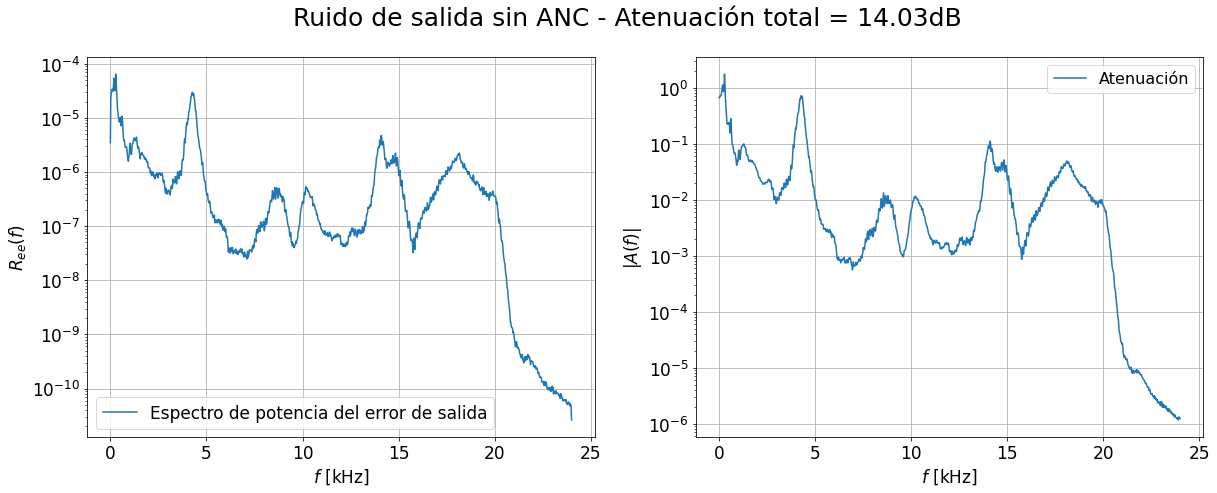

In [44]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True)
headphone.set_noise(x_white)

# Plot
plot_error_analysis(x_white, headphone.d, fs, 'Ruido de salida sin ANC', a_weighting=False)

Lo que se puede ver aquí es que simplemente teniendo el auricular utilizado en las mediciones con un ruido blanco de entrada, se tiene una atenuación de 13.9dB, por la atenuación debida a la propia construcción del auricular.

# 2. Modelado del camino acústico primario $P(z)$
En esta sección, se propone una primera iteración del sistema para modelar el camino acústico primario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_01.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_01.png" style='width: 600px;'></center></td>
    </tr>
</table>

In [53]:
import time

In [54]:
def anc_montecarlo(iterations, model, anc, size, order, step):
    """ Run a montecarlo simulation for the ANC system provided.
        @param iterations Amount of iterations for the simulation
        @param model Instance of an AcousticModel
        @param anc Function that executes the active noise cancelling
        @param size Amount of samples for iteration
        @param order Order of the FIR for the adaptive filter
        @param step Step size for LMS based algorithm
        @return Error and coefficients evolution for each iteration
    """
    
    # Create an instance of the acoustic model to be used
    # and generate a sample function of the input noise x(n)
    # to run the simulation. We are using white gaussian noise.
    noise = np.random.normal(size=size)
    model.set_noise(noise)
    
    # Initialize arrays used to register the error and coefficients
    # to be averaged and plotted at the end of the montecarlo simulation
    e = np.zeros((iterations, size))
    w = np.zeros((iterations, order, size))
    
    # Run each simulation
    for i in range(iterations):
        print(f'Running simulation {i + 1} of {iterations}')
        start_time = time.time()
        e_i, w_i = anc(model, order, step)
        end_time = time.time()
        e[i,:] = e_i
        w[i,:,:] = w_i
        model.reset()
        print(f'Finished in {np.round(end_time - start_time, 5)} s')
    
    # Return simulation results
    return e, w

In [55]:
def anc_primary(model, order, step, weight_history=False):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing the error signal, the last coefficients and the coefficient evolution (if enabled)
                (error_signal, ast_coefficients, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    w = np.zeros(order)
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()
        y = -np.dot(w, r)
        model.speaker(y)
        e = model.error_microphone()
        w += step * r * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

## 2.1. Prueba del algoritmo
En esta sección se prueba el algoritmo con un sistema simulado, para verificar el funcionamiento de la implementación.
Para la elección del orden del filtro LMS, se debe elegir un orden igual o mayor al del filtro que se quiere estimar.

Como en este trabajo siempre se conoce el orden del filtro que se quiere estimar, se elige empíricamente un orden acorde. En una aplicación real, el camino primario a estimar varía con el entorno, dependiendo de las reflexiones de la habitación por ejemplo, por lo que se debe elegir un orden suficiente para una cierta cantidad de ambientes.

In [70]:
# Create the simulated headphone and the test noise
headphone = Test(secondary_enable=False)
headphone.set_noise(x)

# Run the algorithm
test1_e, test1_w = anc_primary(headphone, order=20, step=0.001)

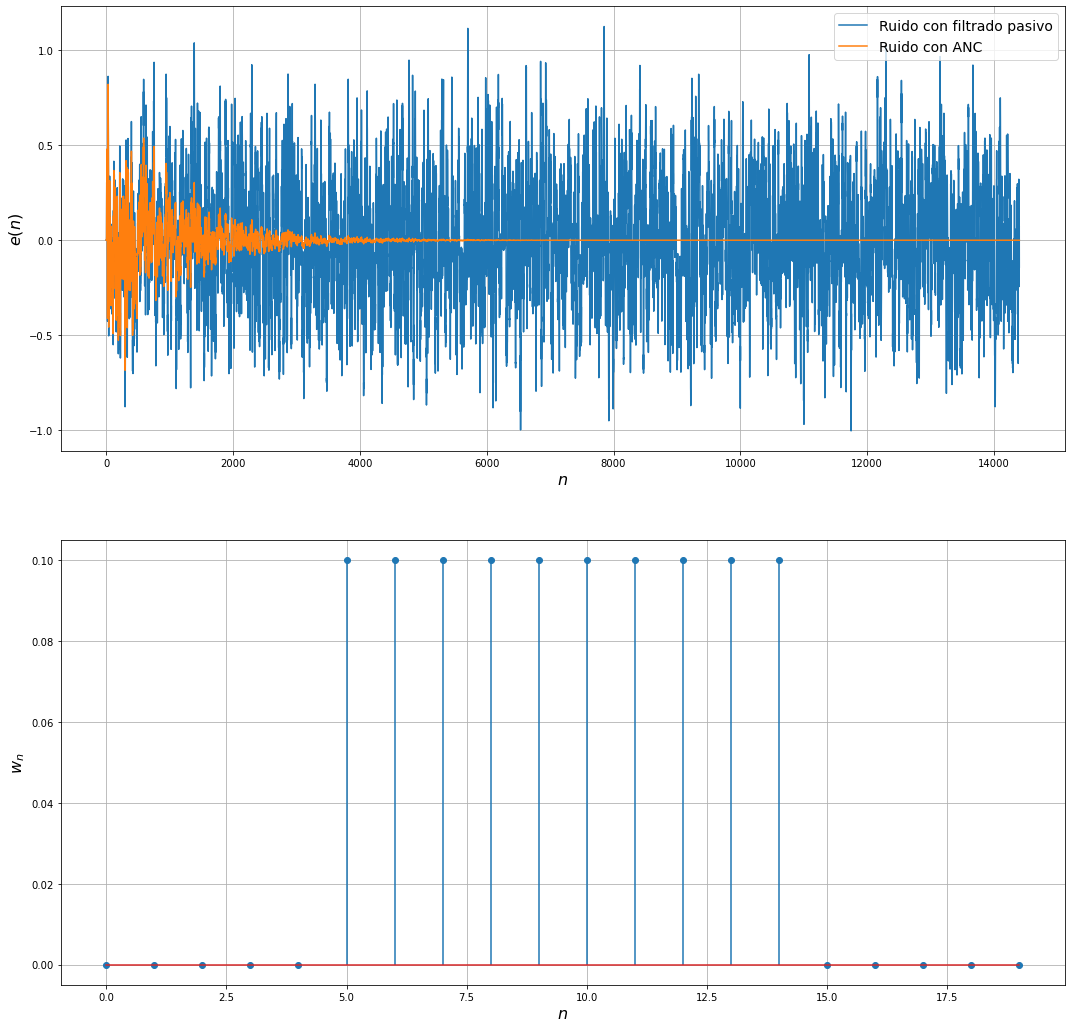

In [71]:
# Plot the ANC results
plot_anc_results([headphone.d, test1_e], test1_w, weight_plot='response')

In [72]:
# Listen the result
IPython.display.Audio(test1_e, rate=fs)

## 2.2. Usando BoseQC20
En esta sección se prueba el algoritmo sobre el modelo acústico de los auriculares BoseQC20.

In [93]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=False)
headphone.set_noise(x)

# Run the algorithm
it1_e, it1_w = anc_primary(headphone, order=2000, step=0.0001)

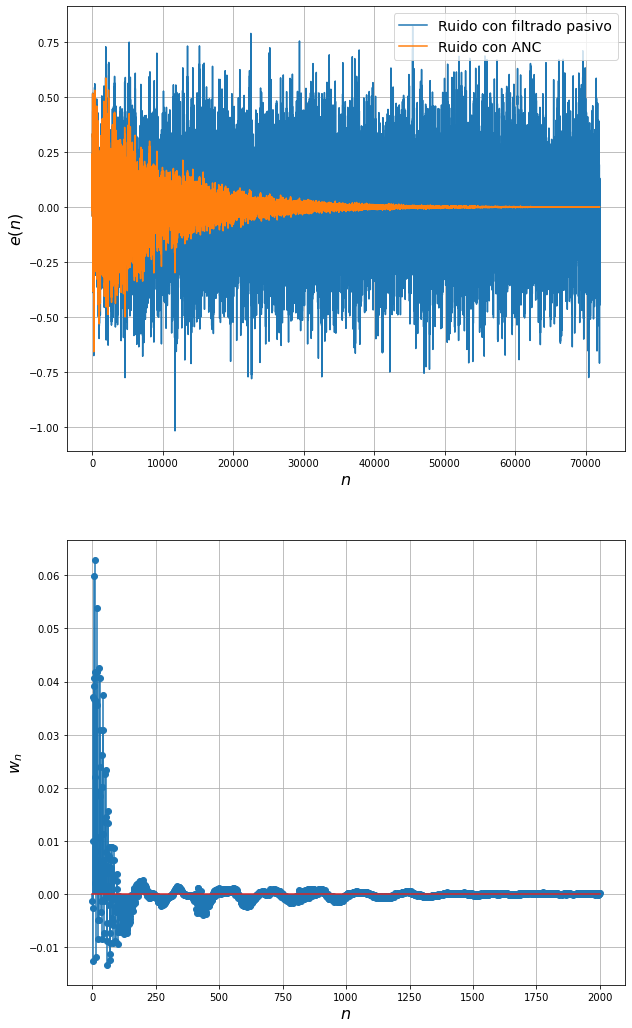

In [106]:
# Plot the ANC results
plot_anc_results([headphone.d, it1_e], it1_w, weight_plot='response')

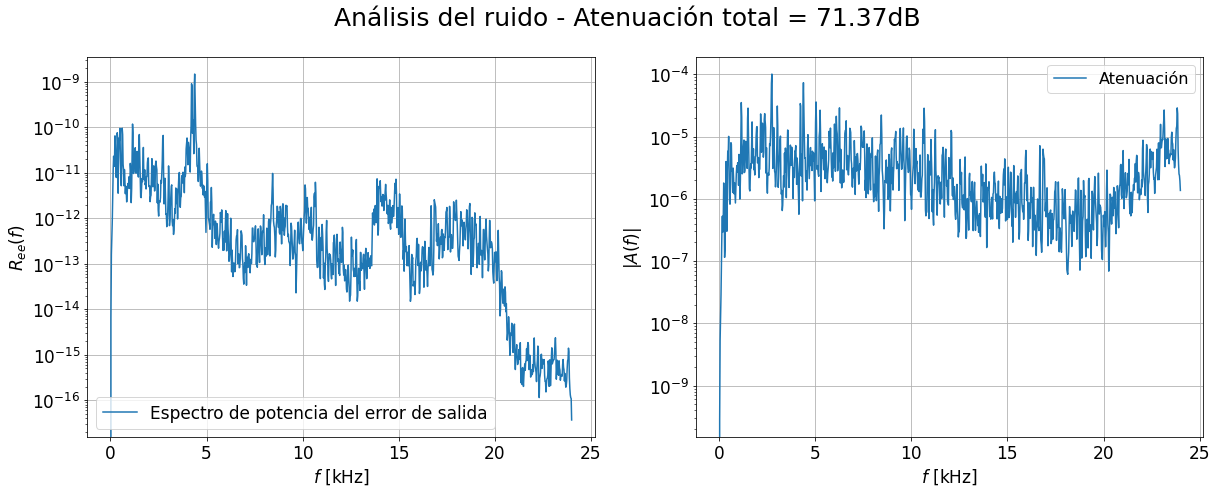

In [201]:
# Plot the attenuation analysis
plot_error_analysis(headphone.d[60000:], it1_e[60000:], fs, 'Análisis del ruido', a_weighting=True)

In [97]:
# Listen the result
IPython.display.Audio(it1_e, rate=fs)

## 2.3. Simulando el camino secundario con la iteración 1

In [81]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True)
headphone.set_noise(x)

# Run the algorithm
it1_2_e, it1_2_w = anc_primary(headphone, order=2000, step=0.00001)

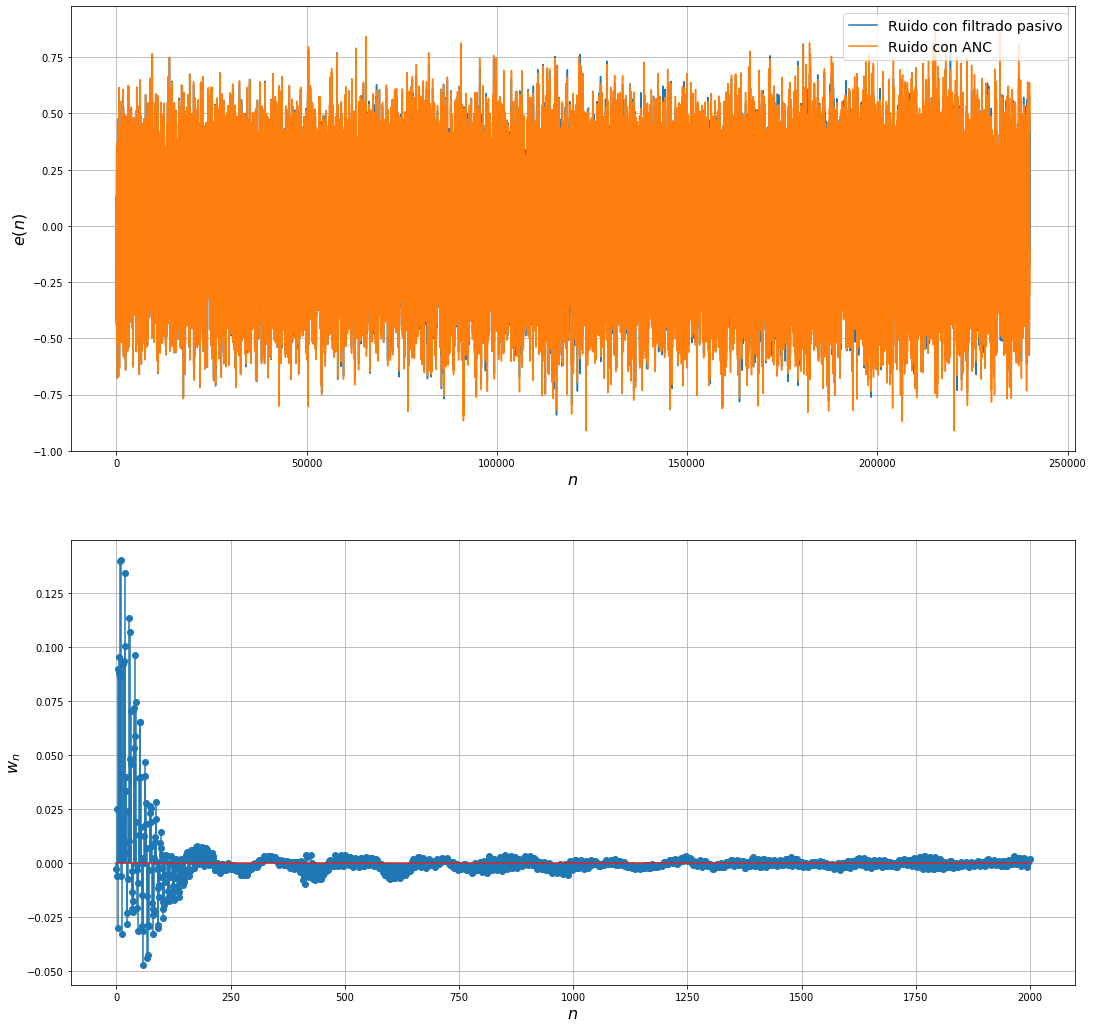

In [82]:
# Plot the ANC results
plot_anc_results([headphone.d, it1_2_e], it1_2_w, weight_plot='response')

In [83]:
# Listen the result
IPython.display.Audio(it1_2_e, rate=fs)

# 3. Compensando el camino acústico primario $P(z)$ y agregando NLMS
En esta sección, se propone una segunda iteración del sistema que considera la variación en la energía de entrada del ruido a cancelar, y ajusta el parámetro de paso acordemente.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_02.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_02.png" style='width: 600px;'></center></td>
    </tr>
</table>

Se utilizará el ruido de subte para estudiar el comportamiento de esta iteración, debido a que se observó que es de los que más variación tiene en su energía. Primero se muestra el comportamiento del sistema como está hasta este punto, para este ruido con energía variable.

### Ruido de subte

In [84]:
from scipy.io.wavfile import read

In [85]:
white_noise = [np.random.normal(size=dtt), "White"]
airport_noise = [np.array(read("../samples/airport.wav")[1], dtype=float), "Airport"]
car_noise = [np.array(read("../samples/car.wav")[1], dtype=float), "Car"]
exhibition_noise = [np.array(read("../samples/exhibition.wav")[1], dtype=float), "Exhibition"]
restaurant_noise = [np.array(read("../samples/restaurant.wav")[1], dtype=float), "Restaurant"]
street_noise = [np.array(read("../samples/street.wav")[1], dtype=float), "Street"]
subway_noise = [np.array(read("../samples/subway.wav")[1], dtype=float), "Subway"]
train_noise = [np.array(read("../samples/train.wav")[1], dtype=float), "Train"]

In [86]:
x = subway_noise[0]
x /= x.max()

In [87]:
def anc_primary_nlms(model, order, step, delta=1e-7):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing the error signal and the coefficients evolution
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    w = np.zeros(order)
    e_n = np.zeros(N)
    w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        # Take a new input sample and update the input buffer of the digital filter
        # by rolling the numpy array one place and introducing the new sample
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()

        # Compute the output sample
        y = -np.dot(w, r)
        model.speaker(y)

        # Take a new error sample
        e = model.error_microphone()

        # Update the digital filter coefficients
        w += step / ((np.dot(r, r) / len(r)) + delta) * r * e

        # Save history
        e_n[i] = e
        w_n[:,i] = w
        i += 1
    
    return e_n, w_n

In [88]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it3_e, it3_w = anc_primary(headphone, order=2000, step=0.015)

Se compara en el siguiente gráfico la señal de error del sistema ANC (naranja) con la señal atenuada por el propio auricular (pasando por $ P(z) $), es decir, la atenuación pasiva (azul).

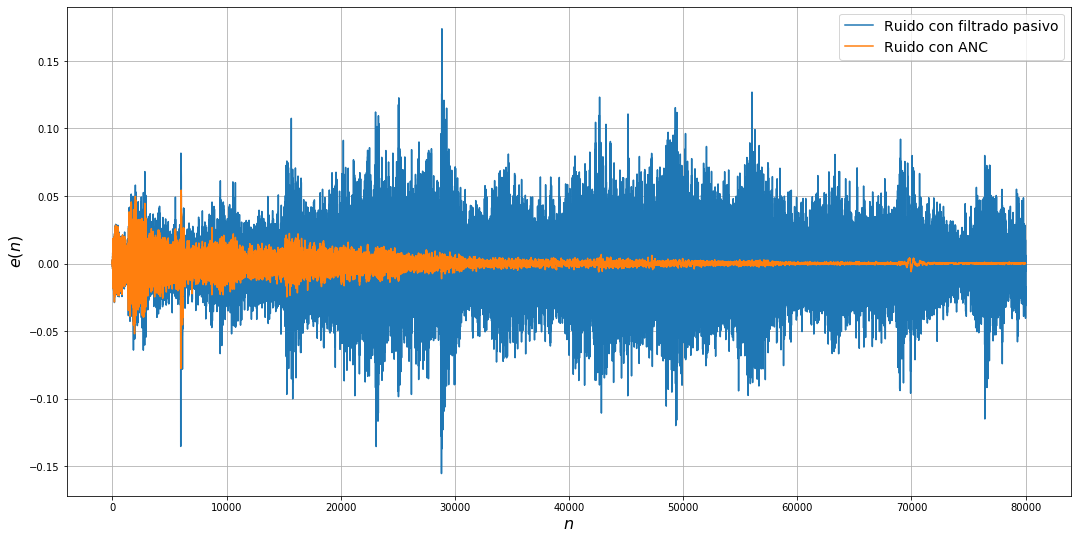

In [89]:
plot_anc_results([headphone.d, it3_e])

In [90]:
IPython.display.Audio(it3_e*10, rate=fs, normalize=False)

Se observa que si bien el sistema funciona a la larga, en varios puntos donde se observan cambios en la energía de la señal de entrada, la señal de error es suceptible a ellos y crece. Los valores en torno a la muestra 15000 y 70000 son claros ejemplos de esto. La introducción de NMLS viene justamente a suplir estas falencias.

In [91]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it3_e_n, it3_w_n = anc_primary_nlms(headphone, order=2000, step=0.0005, delta=1e-7)

Ahora se superpone a las señales de cancelación pasiva (azul) y error del LMS con el camino primario (naranja), el error obtenido de aplicar NLMS a la compensación del camino primario (verde). Para la normalización se utiliza una estimación de la energía de entrada dada por:

$$ || r(n) ||^2 \approx \frac{1}{N} \sum_{k=0}^{N-1} r^2(n-k) $$

Donde $ N $ es el orden del filtro adaptativo utilizado, ya que si se asume estacionareidad local para esa cantidad de muestras, también será valido el mismo criterio para la estimación de la energía.
Para protejerse contra problemas numéricos debido a posibles partes de la señal en que la energía sea muy baja (y que esto afecte negativamente al estar dividiendo), se incorpora una constante $ \delta $ en la actualización del parámetro de paso, de forma que:

$$ \mu = \frac{\tilde{\mu}}{|| r(n) ||^2 + \delta} $$

Se elige $ \delta = 1 \cdot 10^{-7} $ ya que se observó que ese valor se encuentra un órden de magnitud por debajo de los valores usuales más bajos de energía de entrada. En consecuencia, evita problemas excepcionales por energía de entrada inusualmente baja, y en condiciones normales es un término despreciable.

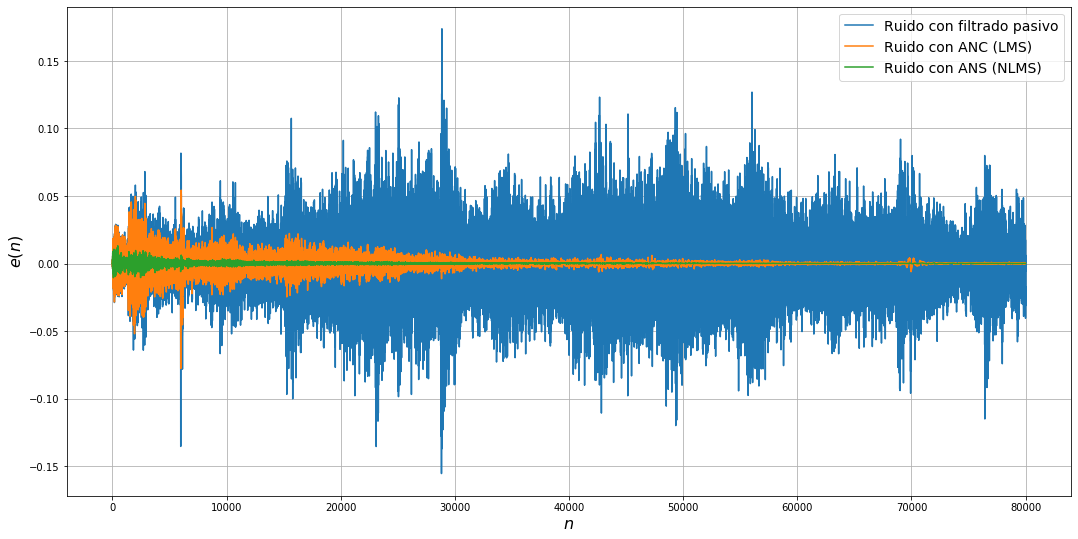

In [92]:
plot_anc_results([headphone.d, it3_e, it3_e_n], labels=['Ruido con filtrado pasivo', 'Ruido con ANC (LMS)', 'Ruido con ANS (NLMS)'])

In [93]:
IPython.display.Audio(it3_e_n*10, rate=fs, normalize=False)

En primer lugar, se observan mejorías considerables en la velocidad de convergencia, respecto del algoritmo con LMS, pero más importante, en lo que respecta al uso de NLMS, es la invarianza lograda ante las variaciones de energía en la señal de entrada. En zonas donde la iteración previa sufría estos cambios (en torno a las muestras 15000 y 70000), ahora la nueva iteración no presenta cambios en su error, indicando un ajuste en línea del parámetro de paso adecuado.

A continuación se probará de utilizar el mismo parámetro de paso que se empleó previamente para el ruido de subte, pero para los otros contextos de ruido, para verificar que sin importar el tipo de señal que se reciba ni su energía, el uso de NLMS se adapta a esto contextos.

### Ruido blanco

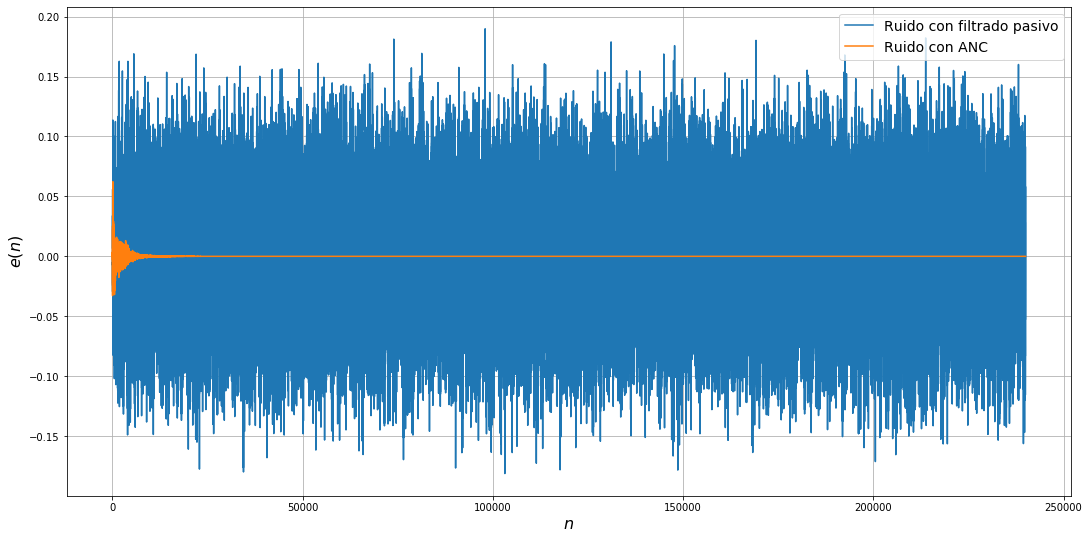

In [94]:
x = white_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de aeropuerto

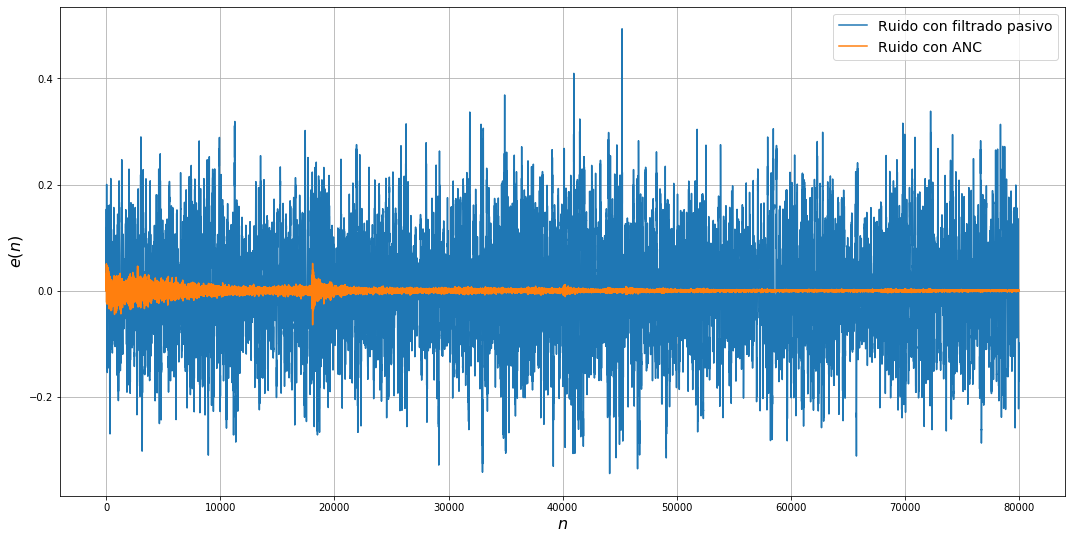

In [95]:
x = airport_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de auto

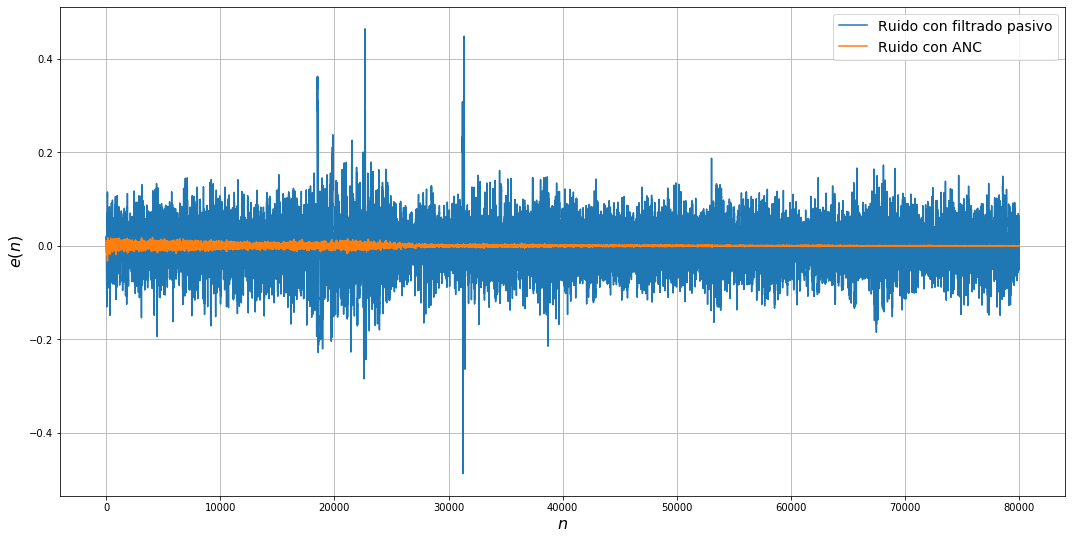

In [96]:
x = car_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de exhibición

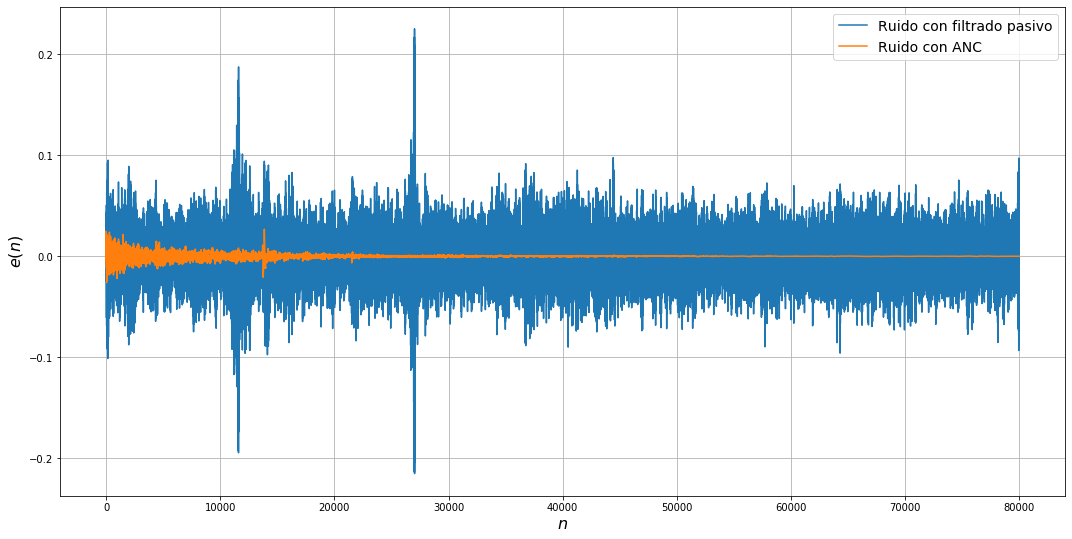

In [97]:
x = exhibition_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de restaurante

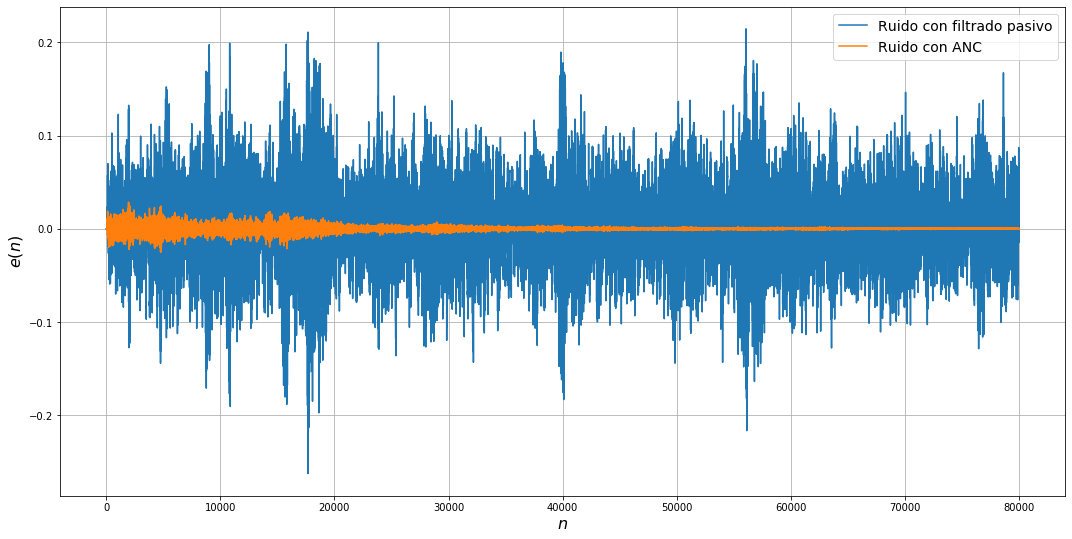

In [98]:
x = restaurant_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de calle

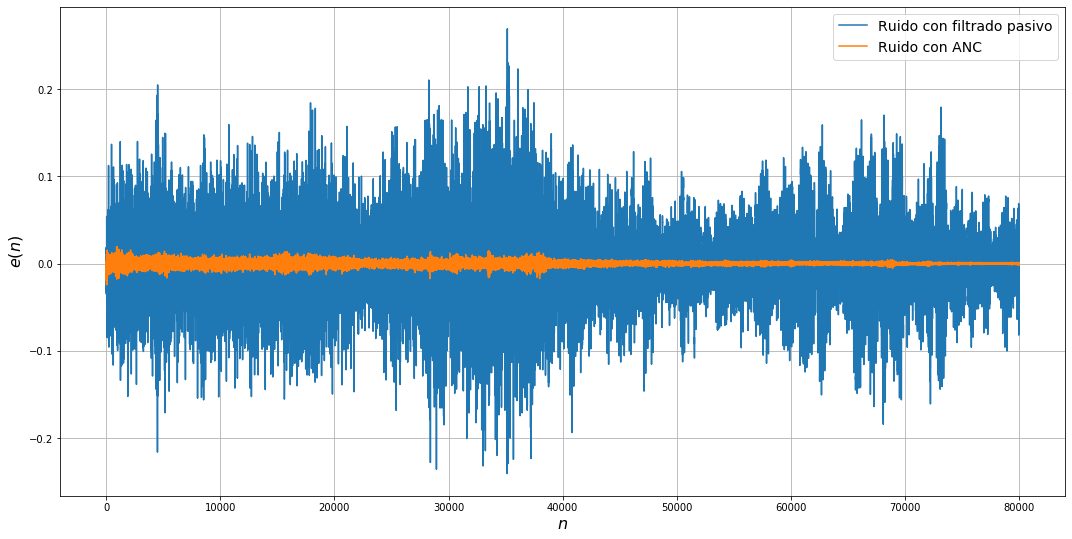

In [99]:
x = street_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de tren

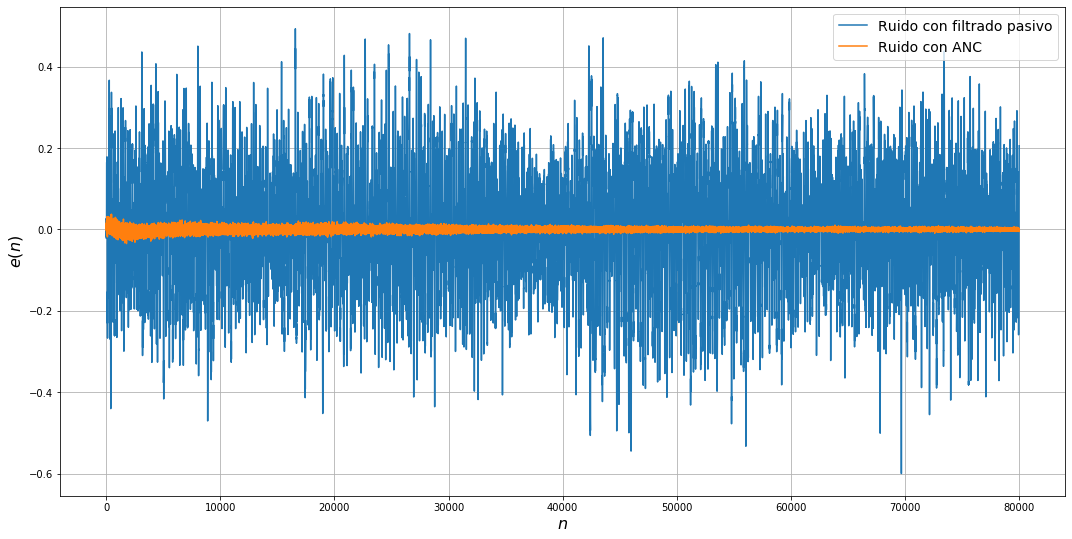

In [100]:
x = train_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

Del análisis de los gráficos anteriores, se deduce que la utilización de NLMS fue propiciosa, ya que el algorítmo muestra compensar las variaciones en la energía de entrada, para distintos contextos de ruido, y todo bajo el mismo parámetro de paso.

# 4. Compensando el camino acústico secundario $G(z)$
En esta sección, se propone una tercera iteración del sistema para compensar el camino acústico secundario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_03.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_03.png" style='width: 600px;'></center></td>
    </tr>
</table>

### 4.1. Estimación de $\hat{G}(z)$ fuera de línea
En la práctica, para los auriculares sobre los que se quiere aplicar el algoritmo de cancelación activa de ruido, es necesario utilizar un esquema de identificación de sistemas generando una excitación aplicada al parlante de los auriculares, midiendo la respuesta a través del micrófono de error. Para esto, se puede utilizar una señal con un barrido lineal/exponencial de frecuencia que excite todas las frecuencias del espectro audible, y teniendo el sistema fuera de línea, con la medición de la señal del micrófono de error encontrar una estimación aceptable del camino acústico secundario.

A los efectos de este trabajo, ese camino acústico secundario ya se encuentra estimado en la base de datos. Por ende, se utilizará $\hat{g}(n)$ considerándola ya estimada, y se pondrá el foco en el algoritmo en línea, para cancelar de forma activa el ruido.

### 4.2. Algoritmo FX-LMS

In [174]:
def anc_primary_secondary(model, g, order, step, initial_weights=None, weight_history=False):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param order Order of the filter
        @param step Step size used for LMS
        @param initial_weights Initialization of weights
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    w = np.zeros(order) if initial_weights is None else initial_weights
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    e = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        rg[0] = rw[0] = model.reference_microphone()
        rlms[0] = np.dot(g, rg)
        y = -np.dot(w, rw)
        model.speaker(y)
        e = model.error_microphone()
        w += step * rlms * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

### 4.3. Prueba del algoritmo
En esta sección se prueba el algoritmo con un sistema simulado, para verificar el funcionamiento de la implementación.

In [125]:
# Choose test signal
x = np.random.normal(size=150000)

In [128]:
# Create the simulated headphone and the test noise
headphone = Test(secondary_enable=True)
headphone.set_noise(x)

# Run the algorithm
test2_e, test2_w = anc_primary_secondary(headphone, headphone.g, order=20, step=0.000001)

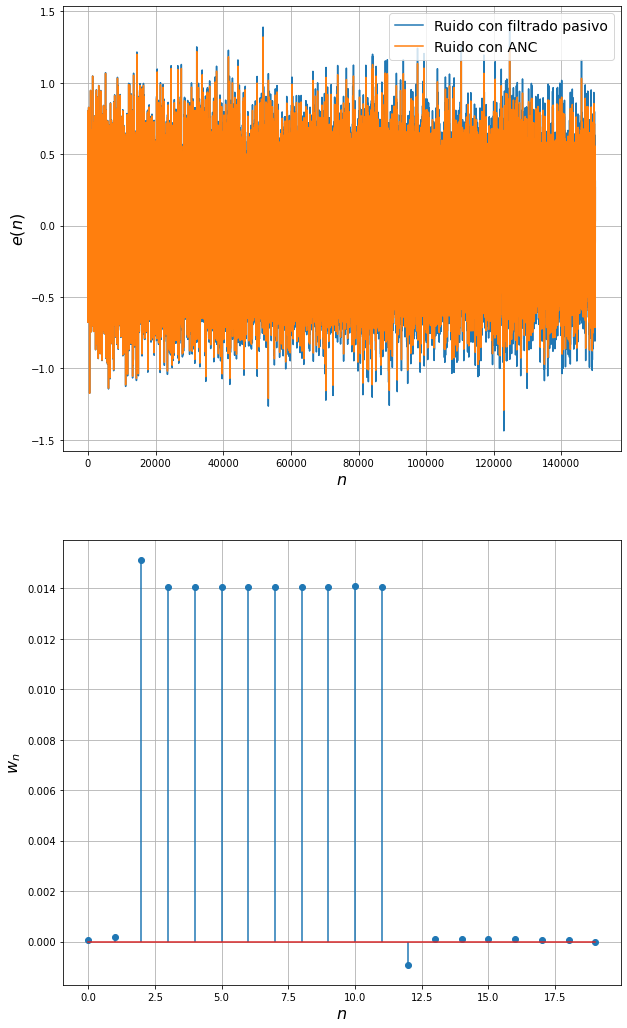

In [129]:
# Plot the ANC results
plot_anc_results([headphone.d, test2_e], test2_w, weight_plot='response')

### 4.4. Usando BoseQC20
En esta sección se prueba el algoritmo sobre el modelo acústico de los auriculares BoseQC20.

In [196]:
x = np.random.normal(size=1200000)

In [197]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True)
headphone.set_noise(x)

# Run the algorithm
it2_e, it2_w = anc_primary_secondary(headphone, headphone.g, order=2000, step=0.004)

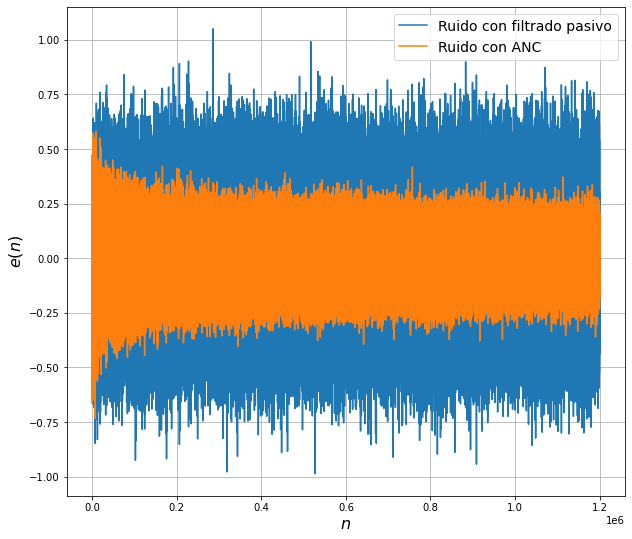

In [198]:
# Plot the ANC results
plot_anc_results([headphone.d, it2_e])

In [202]:
# Listen the audio
IPython.display.Audio(it2_e, rate=fs)

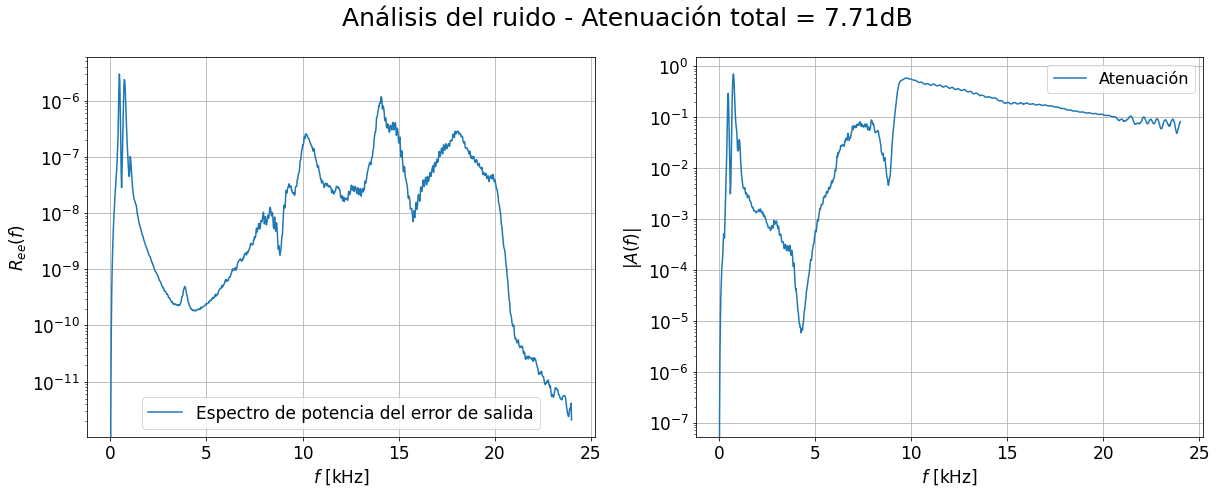

In [203]:
# Plot the attenuation analysis
plot_error_analysis(headphone.d[550000:], it2_e[550000:], fs, 'Análisis del ruido', a_weighting=True)

En primera instancia, se observa que a pesar de la inclusión de la compensación del camino secundario en el algoritmo, la cancelación de ruido es poco satisfactoria y apenas produce mejoras a la atenuación propia y pasiva del auricular. Se estudian a continuación las posibles razones por las cuales esto ocurre.

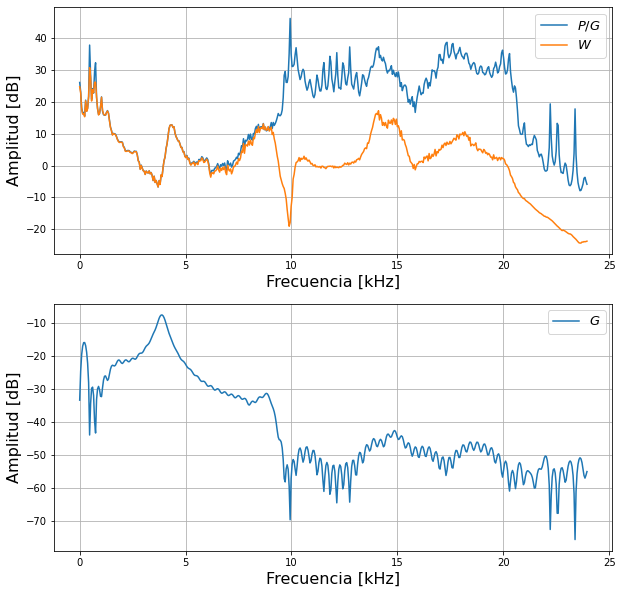

In [206]:
plot_frequency_analysis(headphone.p, headphone.g, it2_w, fs)

De los gráficos anteriores en frecuencia se observa que el filtro adaptativo parece estar acercándose a la transferencia deseada $ \frac{P(z)}{G(z)} $ en recuencias bajas (aproximadamente hasta los $ 5 \text{kHz} $), pero pierde el seguimiento para frecuencias mayores a esta. Esto es inicialmente llamativo, dado que la entrada es de ruido blanco, y esta excita de la misma manera a todos los modos. Sin embargo, inspeccionando el segundo gráfico (respuesta en frecuencia de $ G(z) $), obtenemos una razón a este comportamiento. En todas las frecuencias, $ G(z) $ atenúa, pero esta atenuación se acentúa luego de los $ 8 \text{kHz} $, y cabe entonces recordar el esquema del algoritmo al inicio de esta sección, el cual indica que la entrada es previamente filtrada por $ G(z) $ antes de ingresar al bloque de LMS. En otras palabras, la entrada al algoritmo LMS no es ruido blanco, sino que esta coloreado, y de tal forma que atenúa considerablemente frecuencias por encima de $ 8 \text{kHz} $. Como estas componentes de frecuencia son tan bajas en la entrada del algoritmo, a este le cuesta adaptar correctamente su filtro para esos modos, resultando en una mala adaptación.

Para evaluar esta hipótesis, se realizan varias iteraciones del algoritmo, en las cuales cada nueva iteración se inicializa con los coeficientes logrados en el ultimo paso por la iteración anterior (en otras palabras, se corre el algoritmo por más tiempo). Luego de varias iteraciones se llega a una transferencia como la siguiente. 

<img src='../support/image/result_iterations.png'></img>

Otra forma de analizar lo que sucede es mediante el estudio de los autovalores del sistema, los cuales tienen un efecto directo sobre la convergencia del mismo. Si la entrada fuese ruido blanco, todos sus autovalores serían de igual magnitud. Sin embargo, como se dijo antes, al estar la entrada filtrada por $ G(z) $, esta pasa a ser ruido coloreado, y en particular uno con una banda de frecuencia considerablemente atenuada.

Se grafican a continuación los autovalores del sistema.

In [108]:
# Filtered noise
xg = signal.lfilter(headphone.g, [1.0], x_white)
plot_all(fs, xg, 'Ruido Filtrado', 0, order=2000)

TypeError: 'int' object is not subscriptable

Del gráfico anterior se puede observar que existe un alto spread de autovalores, que van de ordenes $ 10^{-1} $ hasta $ 10^{-7} $. Esto se condice con lo mencionado anteriormente, ya que aquellos autovalores de valor muy bajo tardarán mucho más en converger.

### 4.5. Ruido coloreado a la entrada
Como se vio que el algoritmo tiene problemas para estimar $P/G$ donde $G$ tiene poca amplitud, se pueba utilizar como entrada un ruido coloreado, obtenido filtrando el ruido blanco de entrada con un pasabanda de $2kHz$ a $5kHz$, frecuencias donde W estima bien para el ruido blanco.

In [109]:
# Coloured band-pass noise 
b, a = signal.butter(8, [2e3, 5e3], btype='bandpass', fs=fs)
w,h = signal.freqz(b,a,fs=fs)
x_bp = signal.lfilter(b, a, x_white)

In [110]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True)
# headphone = Test(secondary_enable=True)
headphone.set_noise(x_bp)
# Run the 2nd iteration of the algorithm 
it2bis_e, it2bis_w = anc_primary_secondary(headphone, headphone.g, order=4000, step=0.003)

In [111]:
# Attenuations list
As = []

In [112]:
for k in range(5):
    break
    A, _ = total_attenuation(x_bp[60000:], it2bis_e[60000:], fs=fs, nperseg=2048)
    print(f'Atenuacion total iteración {k}: {A:.2f}dB')
    As.append(A)
    headphone.reset()
    # Run the 2nd iteration of the algorithm
    it2bis_e, it2bis_w = anc_primary_secondary(headphone, headphone.g, order=4000, step=0.003, initial_weights=it2bis_w)

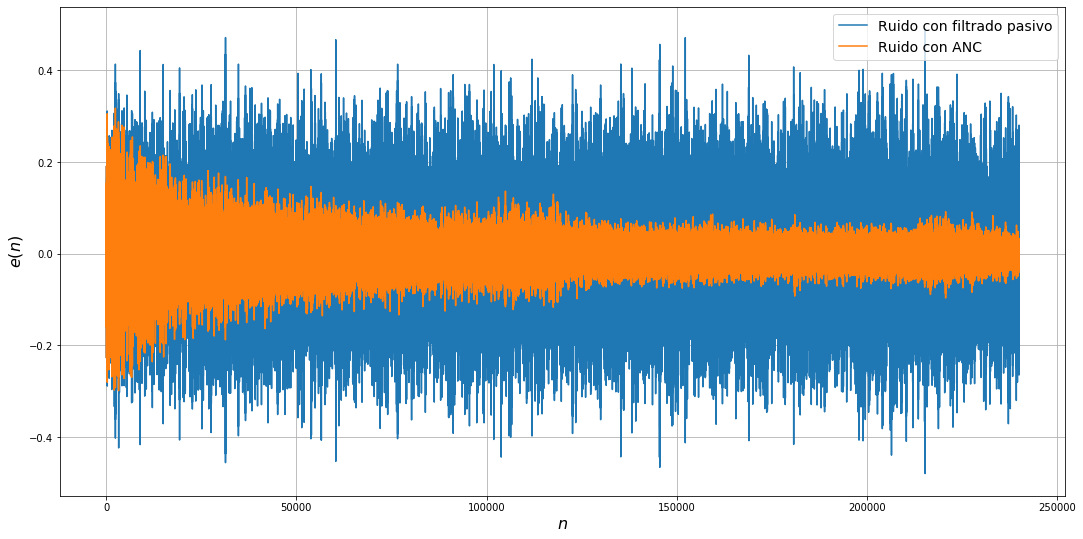

In [113]:
# Plot the ANC results
plot_anc_results([headphone.d, it2bis_e])

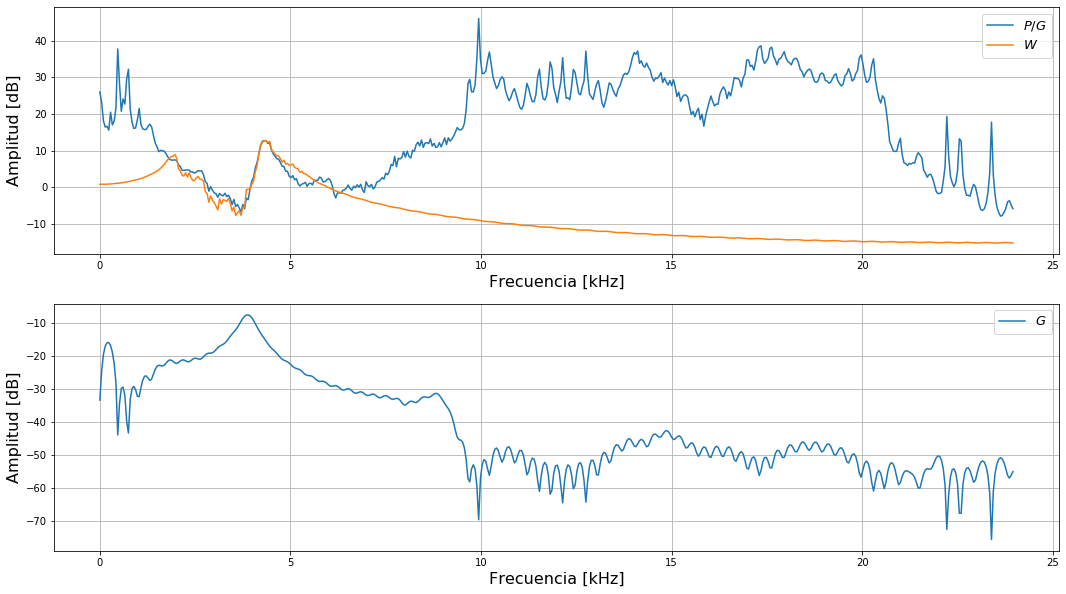

In [114]:
plot_frequency_analysis(headphone.p, headphone.g, it2bis_w, fs)

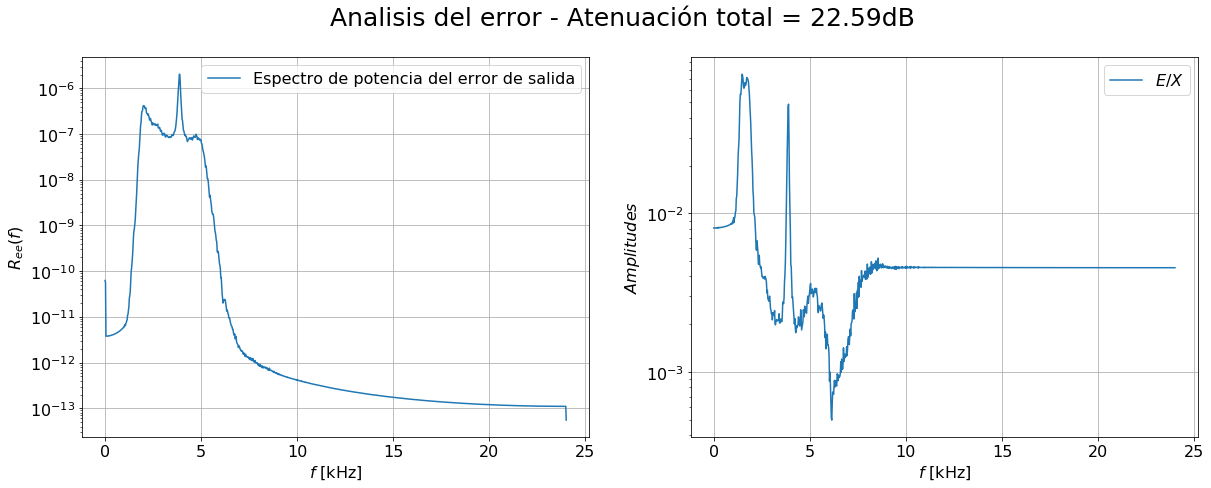

In [115]:
plot_error_analysis(x_bp[60000:], it2bis_e[60000:], fs, 'Analisis del error', a_weighting=False)

# TODO: pulir
La atenuación en este caso es de casi 35dB, una mejora de xdB respecto del ruido blanco debido a estar trabajando en un rango de frecuencias donde $W$ puede adaptarse aceptablemente a $P/G$.

# 5. Compensando el camino de feedback $F(z)$

En esta sección se propone la tercera iteración del sistema para compensar la influencia de la salida en el micrófono de referencia, siendo esta la última modificación a introducir en el modelo del sistema físico.
<table>
    <tr>
        <td><center><img src="../support/drawing/headphone_anc_feedback_path.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_04.png" style='width: 600px;'></center></td>
    </tr>
</table>

### 5.1 Estimación de $\hat{F}(z)$ fuera de línea
Al igual que en el caso de $G(z)$, se utiliza $\hat{f}(n)$ considerádola ya estimada.

### 5.2 Algoritmo compensando $F(z)$

In [116]:
def anc_complete_system(model, g, f, order, step, initial_weights=None, weight_history=False):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary and feedback acoustic paths.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param f Feedback acoustic path 
        @param order Order of the filter
        @param step Step size used for LMS
        @param initial_weights Initialization of weights
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """    
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    y = np.zeros(len(f))       # Buffer for the input of F(z)
    w = np.zeros(order) if initial_weights is None else initial_weights
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        rg[0] = rw[0] = model.reference_microphone()
        feedback = np.dot(f, y)
        rg[0] -= feedback
        rw[0] -= feedback
        y = np.roll(y, 1)
        y[0] = -np.dot(w, rw)
        model.speaker(y[0])
        e = model.error_microphone()
        rlms[0] = np.dot(g, rg)
        w += step * rlms * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

### 5.3. Prueba del algoritmo
En esta sección se prueba el algoritmo con un sistema simulado, para verificar el funcionamiento de la implementación.

In [117]:
headphone = Test(secondary_enable=True, feedback_enable=True)
headphone.set_noise(x)

it4_e, it4_w = anc_complete_system(headphone, g=headphone.g, f=headphone.f, order=20, step=0.005)

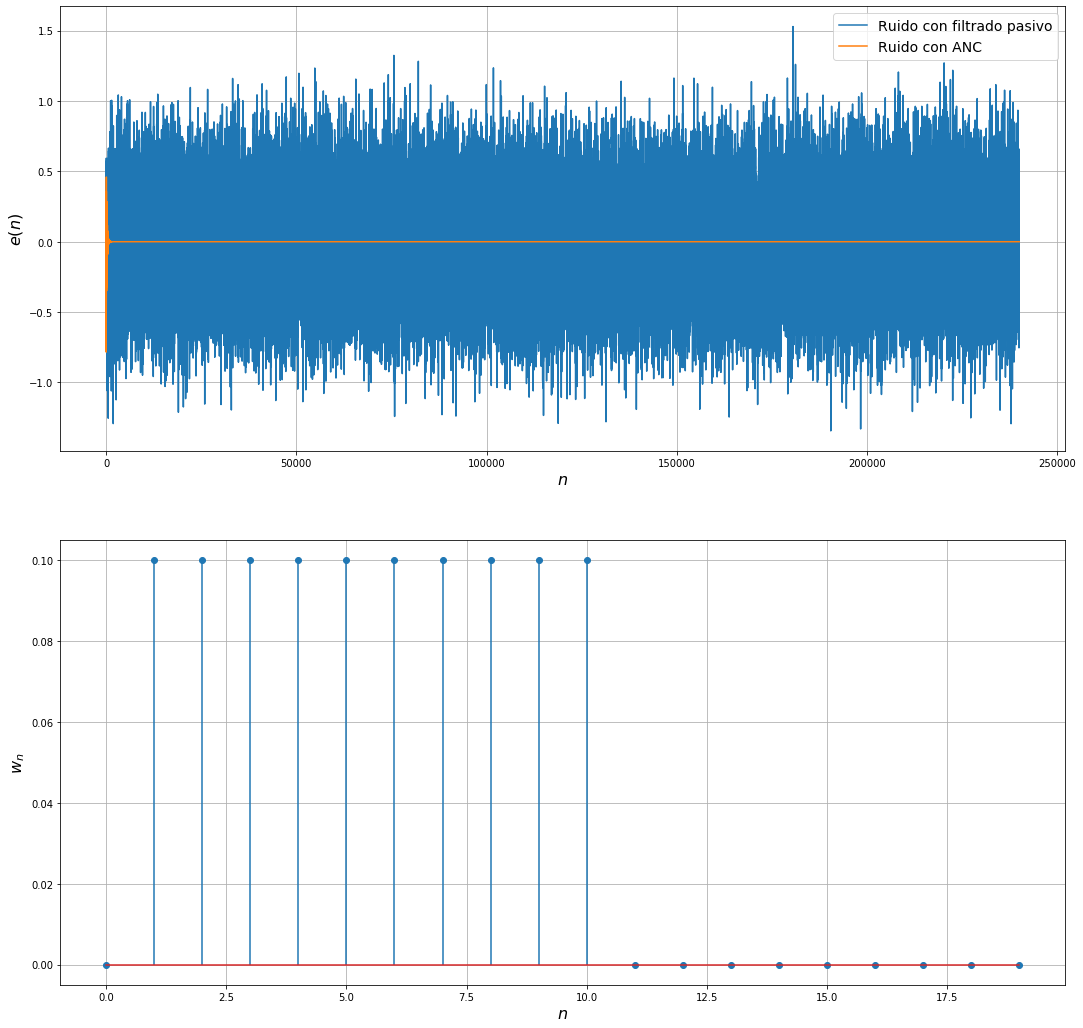

In [118]:
# Plot the ANC results
plot_anc_results([headphone.d, it4_e], it4_w, weight_plot='response')

### 5.4. Usando BoseQC20
Nuevamente, se prueba el algoritmo sobre el modelo acústico de los auriculares BoseQC20.

In [119]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True, feedback_enable=True)
headphone.set_noise(x)

# Run the algorithm
it6_e, it6_w = anc_complete_system(headphone, headphone.g, headphone.f, order=3000, step=0.002)

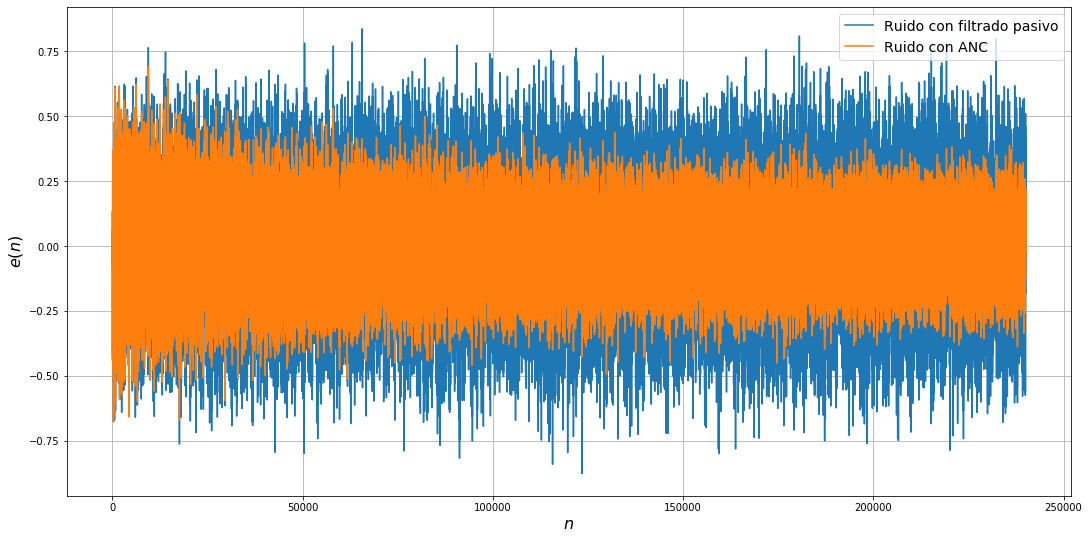

In [120]:
# Plot the ANC results
plot_anc_results([headphone.d, it6_e])

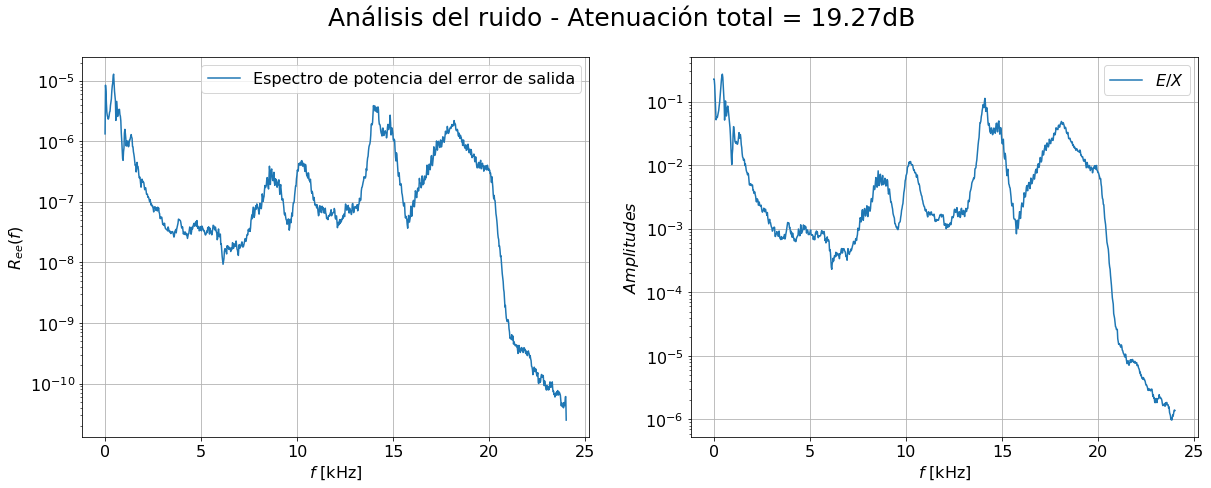

In [121]:
# Plot
plot_error_analysis(x[100000:], it6_e[100000:], fs, 'Análisis del ruido', a_weighting=False)

# 6. Algoritmo final
Se juntan todas las iteraciones propuestas para el algoritmo final.

In [122]:
def anc_complete_system_nlms(model, g, f, order, step, initial_weights=None, weight_history=False, delta=1e-7):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary and feedback acoustic paths.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param f Feedback acoustic path 
        @param order Order of the filter
        @param step Step size used for LMS
        @param initial_weights Initialization of weights
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """    
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    y = np.zeros(len(f))       # Buffer for the input of F(z)
    w = np.zeros(order) if initial_weights is None else initial_weights
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        rg[0] = rw[0] = model.reference_microphone()
        feedback = np.dot(f, y)
        rg[0] -= feedback
        rw[0] -= feedback
        y = np.roll(y, 1)
        y[0] = -np.dot(w, rw)
        model.speaker(y[0])
        e = model.error_microphone()
        rlms[0] = np.dot(g, rg)
        w += step / ((np.dot(rw, rw) / len(rw)) + delta) * rlms * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

In [145]:
x = white_noise[0]
x /= x.max()

In [146]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True, feedback_enable=True)
headphone.set_noise(x)

# Run the algorithm
it6_e, it6_w = anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=3000, step=0.002)

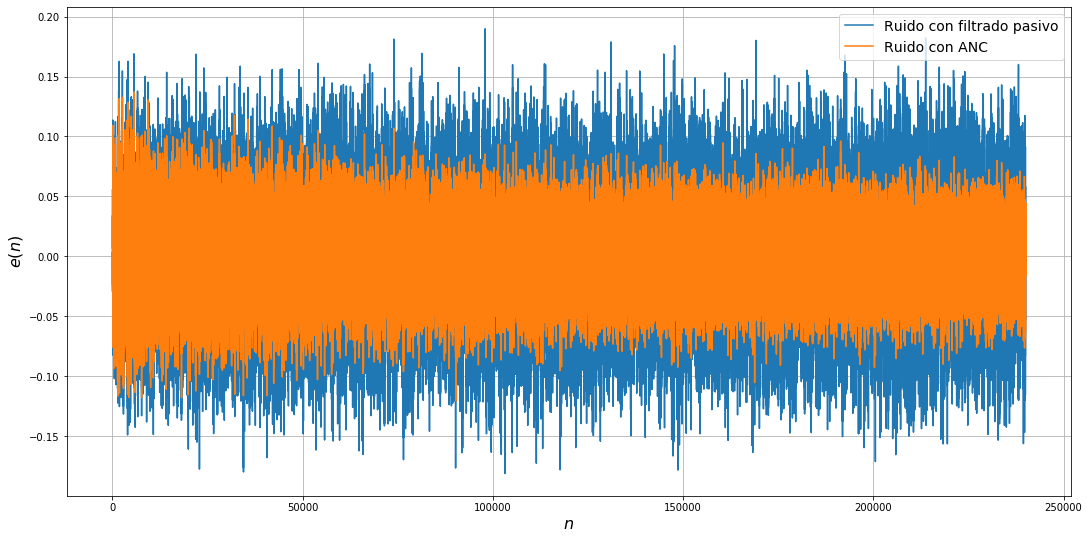

In [147]:
# Plot the ANC results
plot_anc_results([headphone.d, it6_e])

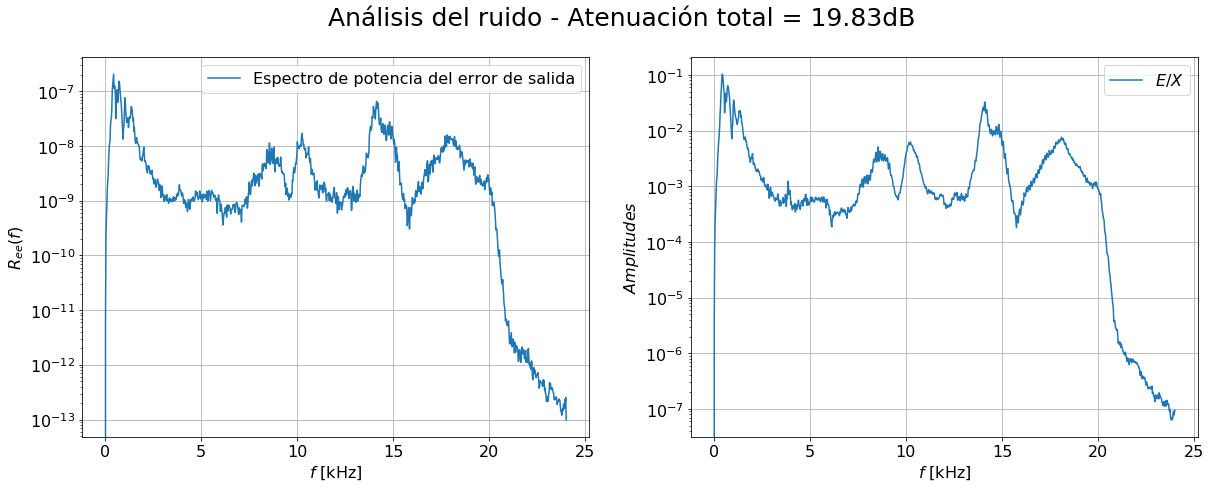

In [152]:
# Plot
n = 200000
plot_error_analysis(x[n:], it6_e[n:], fs, 'Análisis del ruido', a_weighting=True)

In [127]:
x = subway_noise[0]
x /= x.max()

In [128]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True, feedback_enable=True)
headphone.set_noise(x)

# Run the algorithm
it6_e_2, it6_w = anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=3000, step=0.002)

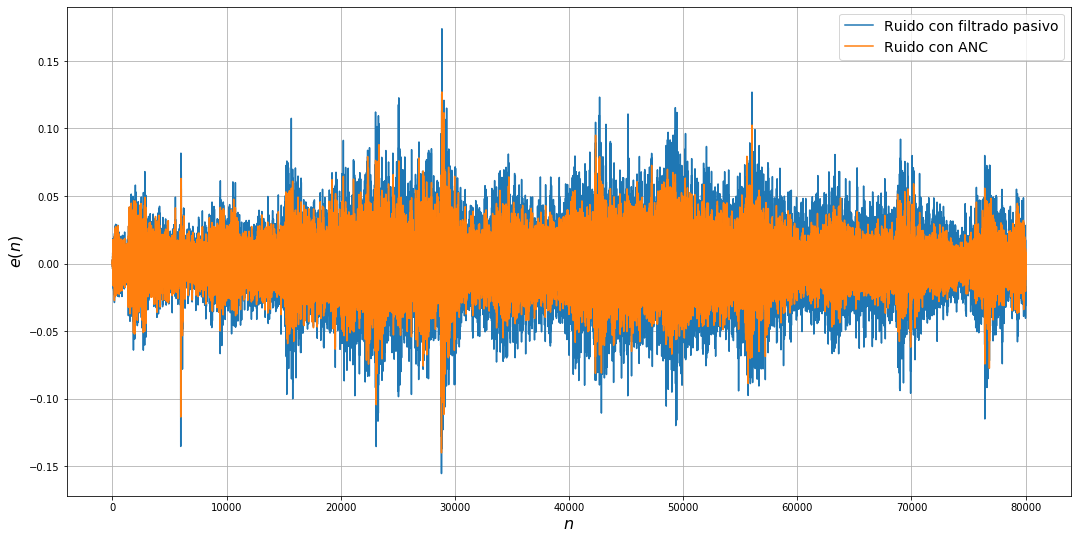

In [129]:
# Plot the ANC results
plot_anc_results([headphone.d, it6_e_2])

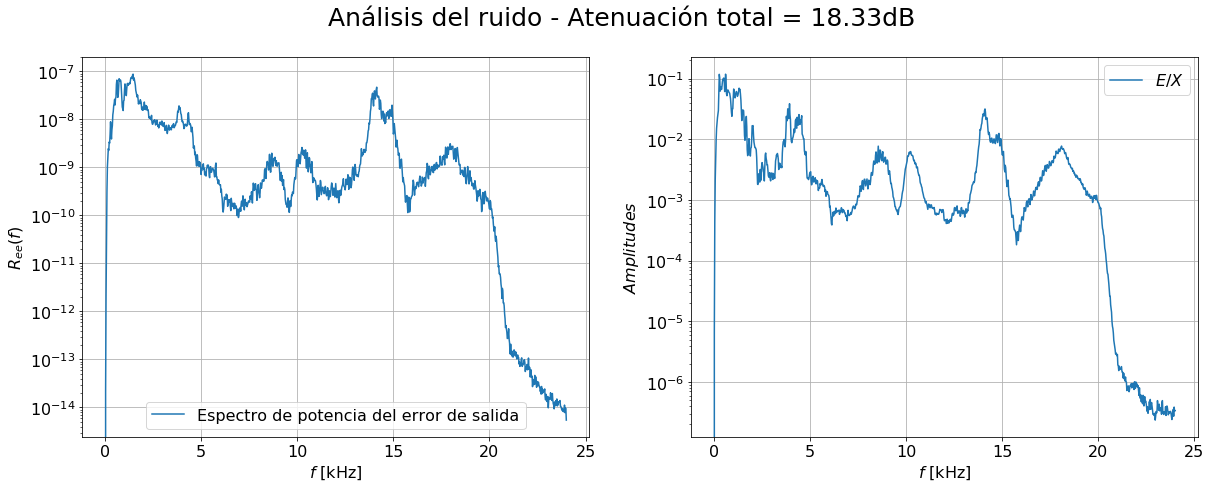

In [130]:
# Plot
plot_error_analysis(x[30000:], it6_e[30000:], fs, 'Análisis del ruido', a_weighting=True)

# 7. Bibliografía
[1] S. Liebich, J. Fabry, P. Jax and P. Vary, "Acoustic path database for ANC in-ear headphone development", Institute of Communication Systems, RWTH Aachen University, Germany

[2] L. J. Eriksson, M. C. Allie, C. D. Bremigan, "Active noise control using adaptive digital signal processing", Corporate Research Department, Nelson Industries, Inc., Stoughton, WI 53589, U.S.A.

[3] M. T. Akhtar, M. Abe, and M. Kawamata, "A New Variable Step Size LMS Algorithm-Based Method for Improved Online Secondary Path Modeling in Active Noise Control Systems", IEEE Transactions on audio, speech, and language processing, VOL. 14, NO. 2, March 2006

[4] M. T. Akhtar, "Narrowband feedback active noise control systems with secondary path modeling using gain-controlled additive random noise", Department of Electrical and Computer Engineering, School of Engineering & Digital Sciences, Nazarbayev University, Nur-Sultan, Kazakhstan

[5] J. Fabry and P. Jax, "Primary path estimator based on individual secondary path for ANC headphones", Institute of Communication Systems, RWTH Aachen University, Germany

[6] B. Mishra, A. Behuria, P. Goel. A Kar, S. Mahapatra and M. Chandra, "An improved feedback Filtered-X NLMS algorithm for noise cancellation", Electronics and Telecommunication Engineering, IIIT Bhubaneswar, Bhubaneswar, India